In [8]:
import sklearn.datasets
import urllib.request

import numpy as np
import matplotlib.pyplot as plt

from optimizer.loss import LogisticRegression
from optimizer.cubic import Cubic, Cubic_LS, Cubic_Krylov_LS, SSCN
from optimizer.GD import Gd, GD_LS
from optimizer.reg_newton import RegNewton

In [9]:
dataset = 'w8a'
    # if dataset == 'mushrooms':
    #     data_url = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/mushrooms"
    #     data_path = './mushrooms'
    # else:
    #     data_url = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/w8a"
    #     data_path = './w8a'
data_url = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/{}".format(dataset)
data_path = './{}'.format(dataset)

f = urllib.request.urlretrieve(data_url, data_path)
A, b = sklearn.datasets.load_svmlight_file(data_path)
A = A.toarray()

In [10]:
print(A.shape)

(49749, 300)


In [11]:
loss = LogisticRegression(A, b, l1=0, l2=0)
n, dim = A.shape
L = loss.smoothness
l2 = 1e-10 * L # make the problem ill-conditioned
loss.l2 = l2
x0 = np.ones(dim) * 0.5
it_max = 200
memory_size = 10

In [12]:
gd = GD_LS(loss=loss, label='GD LS')

cub_krylov = Cubic_Krylov_LS(loss=loss, label='Cubic Newton LS (Krylov dim = {})'.format(memory_size),
                               subspace_dim=memory_size, tolerance = 1e-9)

cub_root = Cubic_LS(loss=loss, label='Cubic Newton LS', tolerance = 1e-8)

adan = RegNewton(loss=loss, adaptive=True, use_line_search=True, 
                    label='AdaN')

In [13]:
print(f'Running optimizer: {gd.label}')
gd.run(x0=x0, it_max=it_max)
gd.compute_loss_of_iterates()

Running optimizer: GD LS


100%|██████████| 200/200 [00:04<00:00, 49.90it/s]


In [14]:
print(f'Running optimizer: {cub_krylov.label}')
cub_krylov.run(x0=x0, it_max=it_max)
cub_krylov.compute_loss_of_iterates()

Running optimizer: Cubic Newton LS (Krylov dim = 10)


100%|██████████| 200/200 [00:29<00:00,  6.70it/s]


In [15]:
print(f'Running optimizer: {adan.label}')
adan.run(x0=x0, it_max=50)
adan.compute_loss_of_iterates()

Running optimizer: AdaN


100%|██████████| 50/50 [00:10<00:00,  4.64it/s]


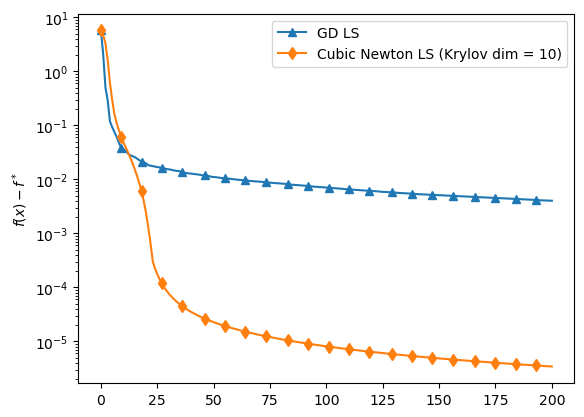

In [16]:
gd.trace.plot_losses(marker='^')
cub_krylov.trace.plot_losses(marker='d')

# cub_root.trace.plot_losses(marker='*', label='cubic Newton (exact)')
# plt.xscale('log')
# print(cub.trace.loss_vals)
plt.yscale('log')
plt.legend()
plt.show()

In [17]:
from optimizer.cubic import Optimizer, Lanczos, cubic_solver_root
from scipy.linalg import eigh

class Cubic_Krylov_LS_test(Optimizer):
    """
    Krylov subspace cubic Newton method with line search
    
    Arguments:
        
    """
    def __init__(self, reg_coef=None, subspace_dim=100, solver_eps=1e-8, beta=0.5, *args, **kwargs):
        super(Cubic_Krylov_LS_test, self).__init__(*args, **kwargs)    
        self.solver_it = 0
        self.subspace_dim = subspace_dim
        self.solver_eps = solver_eps

        self.beta = beta
        self.r0 = 0.1
        # self.residuals = []
        self.value = None

        if reg_coef is None:
            self.reg_coef = self.loss.hessian_lipschitz
        else:
            self.reg_coef = reg_coef
        
        # if cubic_solver == "GD": 
        #     self.cubic_solver = ls_cubic_solver
        # elif cubic_solver == "root":
        #     self.cubic_solver = cubic_solver_root
        # elif cubic_solver == "krylov":
        #     self.cubic_solver = cubic_solver_krylov
        # else:
        #     print("Error: cubic_solver not recognized")

        # if cubic_solver is None:
        #     # self.cubic_solver = ls_cubic_solver
        #     self.cubic_solver = cubic_solver_root
        self.spectra = []
        self.rho = []

    def step(self):
        
        if self.value is None:
            self.value = self.loss.value(self.x)
        
        
        self.grad = self.loss.gradient(self.x)


        self.hess = self.loss.hessian(self.x)
        h_eigs = eigh(self.hess, eigvals_only=True)
        self.spectra.append(h_eigs)

        # if self.cubic_solver is cubic_solver_krylov:    
        self.hess = lambda v: self.loss.hess_vec_prod(self.x,v)
            # krylov_start = time.time()
        V, alphas, betas, beta = Lanczos(self.hess, self.grad, m=self.subspace_dim)
            # krylov_end = time.time()
            # print('Krylov Time {time:.3f}'.format(time=krylov_end - krylov_start))
        self.hess = np.diag(alphas) + np.diag(betas, -1) + np.diag(betas, 1)

        np.append(betas,beta)
        self.rho.append(np.exp(np.log(betas).mean()))

        e1 = np.zeros(len(alphas))
        e1[0] = 1
        self.grad = np.linalg.norm(self.grad)*e1

        if np.linalg.norm(self.grad) < self.tolerance:
            return
        # set the initial value of the regularization coefficient
        reg_coef = self.reg_coef*self.beta

        # LS_start = time.time()

        s_new, solver_it, r0_new, model_decrease = cubic_solver_root(self.grad, self.hess, 
        reg_coef, epsilon = self.solver_eps, r0 = self.r0)
        x_new = self.x + V @ s_new
        value_new = self.loss.value(x_new)
        while value_new > self.value - model_decrease:
            reg_coef = reg_coef/self.beta
            s_new, solver_it, r0_new, model_decrease = cubic_solver_root(self.grad, self.hess, 
            reg_coef, epsilon = self.solver_eps, r0 = self.r0)
            x_new = self.x + V @ s_new
            value_new = self.loss.value(x_new)
        self.x = x_new
        self.reg_coef = reg_coef
        self.value = value_new
        self.r0 = r0_new
        
        self.solver_it += solver_it

        # if model_decrease < 1e-6:
        #     self.subspace_dim = 1
        # self.residuals.append(residual)
        # LS_end = time.time()
        # print('LS Time {time:.3f}'.format(time=LS_end - LS_start))
        
    def init_run(self, *args, **kwargs):
        super(Cubic_Krylov_LS_test, self).init_run(*args, **kwargs)
        self.trace.solver_its = [0]
        
    def update_trace(self):
        super(Cubic_Krylov_LS_test, self).update_trace()
        self.trace.solver_its.append(self.solver_it)

In [18]:
memory_size = 20
cub_krylov_test = Cubic_Krylov_LS_test(loss=loss, label='Cubic Newton LS (Krylov dim = {})'.format(memory_size),
                               subspace_dim=memory_size, tolerance = 1e-9)

In [19]:
print(f'Running optimizer: {cub_krylov_test.label}')
cub_krylov_test.run(x0=x0, it_max=100)
# cub_krylov.compute_loss_of_iterates()

Running optimizer: Cubic Newton LS (Krylov dim = 20)


100%|██████████| 100/100 [00:49<00:00,  2.04it/s]


In [20]:
spectra = np.array(cub_krylov_test.spectra)

In [21]:
spectra.shape

(100, 300)

In [22]:
rho = np.array(cub_krylov_test.rho)

In [23]:
rho

array([0.001239  , 0.00194922, 0.00409076, 0.01104123, 0.0107037 ,
       0.00891361, 0.00571905, 0.00287244, 0.00185447, 0.00140831,
       0.00115378, 0.00111366, 0.00101151, 0.0009546 , 0.00087281,
       0.00079056, 0.00072923, 0.00067624, 0.00065605, 0.00062792,
       0.00063189, 0.00060636, 0.00058143, 0.00057276, 0.00057249,
       0.00056069, 0.00055336, 0.00055532, 0.00057007, 0.00055101,
       0.00055354, 0.00055321, 0.00055746, 0.00057601, 0.00054526,
       0.00056541, 0.00057266, 0.0005681 , 0.00057051, 0.00056549,
       0.00056742, 0.00056399, 0.00056658, 0.00055858, 0.00056506,
       0.0005578 , 0.00056391, 0.00055714, 0.0005483 , 0.00054009,
       0.00055986, 0.00054736, 0.00055807, 0.00053485, 0.00054265,
       0.00054905, 0.00051563, 0.00053841, 0.00055495, 0.00055263,
       0.00056756, 0.00056355, 0.00055948, 0.00054682, 0.00057137,
       0.00053956, 0.00055966, 0.00055749, 0.00056325, 0.00056747,
       0.00057759, 0.00056619, 0.00057714, 0.00056437, 0.00057

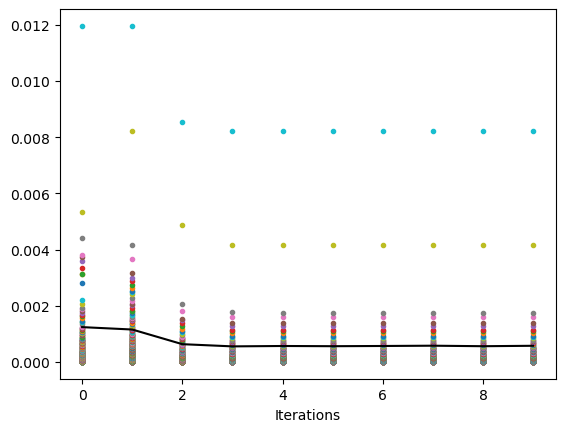

In [31]:
import matplotlib.pyplot as plt
for i in range(spectra.shape[1]):
    plt.plot(spectra[0:-1:10,i],'.')

# plt.figure()
# plt.semilogy(spectra[:,-memory_size], '.')
plt.xlabel('Iterations')
plt.
plt.plot(rho[0:-1:10],'k')
plt.show()

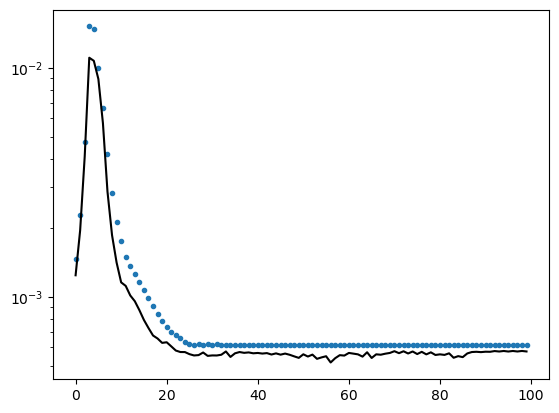

In [30]:
import matplotlib.pyplot as plt
# for i in range(spectra.shape[1]):
# plt.plot(spectra[:,memory_size],'.')

plt.figure()
plt.semilogy(spectra[:,-memory_size], '.')
plt.plot(rho,'k')
plt.show()